In [1]:
!pip install -qqq lyft-dataset-sdk

This code shows how to get points from .bin files in Dataset to train your own neural network.

In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [9]:
INP_DIR = '/home/ys3152/'

In [10]:
# Load the dataset
# Adjust the dataroot parameter below to point to your local dataset path.
# The correct dataset path contains at least the following four folders (or similar): images, lidar, maps, v1.0.1-train
# !ln -s {INP_DIR}/train_images images
# !ln -s {INP_DIR}/train_maps maps
# !ln -s {INP_DIR}/train_lidar lidar

ln: failed to create symbolic link 'images': File exists
ln: failed to create symbolic link 'maps': File exists
ln: failed to create symbolic link 'lidar': File exists


In [16]:
level5data = LyftDataset(
    data_path='/home/ys3152/train_dataset/',
    json_path=os.path.join(INP_DIR + 'train_data'),
    verbose=False
)

In [17]:
my_scene = level5data.scene[0]

In [18]:
my_sample_token = my_scene["first_sample_token"]

In [19]:
my_sample = level5data.get('sample', my_sample_token)

In [20]:
lidar_top_data_token = my_sample['data']['LIDAR_TOP']

In [21]:
lidar_top_data = level5data.get('sample_data', lidar_top_data_token)

In [22]:
# lidar_top_ego_pose_token = lidar_top_data['ego_pose_token']

In [23]:
# # car / lidar top coords
# lidar_top_ego_pose_data = level5data.get('ego_pose', lidar_top_ego_pose_token)
# lidar_top_coords = np.array(lidar_top_ego_pose_data['translation'])

In [24]:
def get_coords_from_ann_idx(ann_idx):
    return np.array(level5data.get('sample_annotation', my_sample['anns'][ann_idx])['translation'])

13: 53370e3cade07cf9a34adf9212ec2b05b028989087d3ce9edb15d03f4acbb2c1


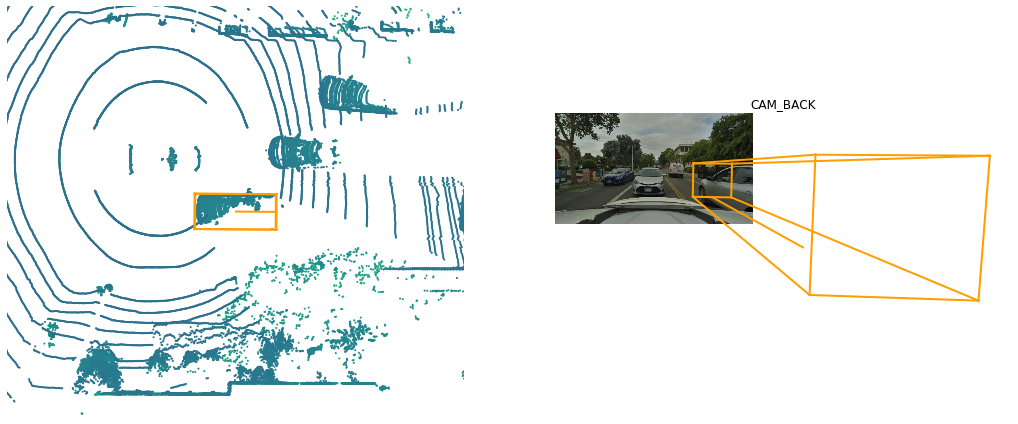

27: 829e30ca8c0b314e4685c4fec7a678c38d50347e2531fe8c4efc861c62ab8ba7


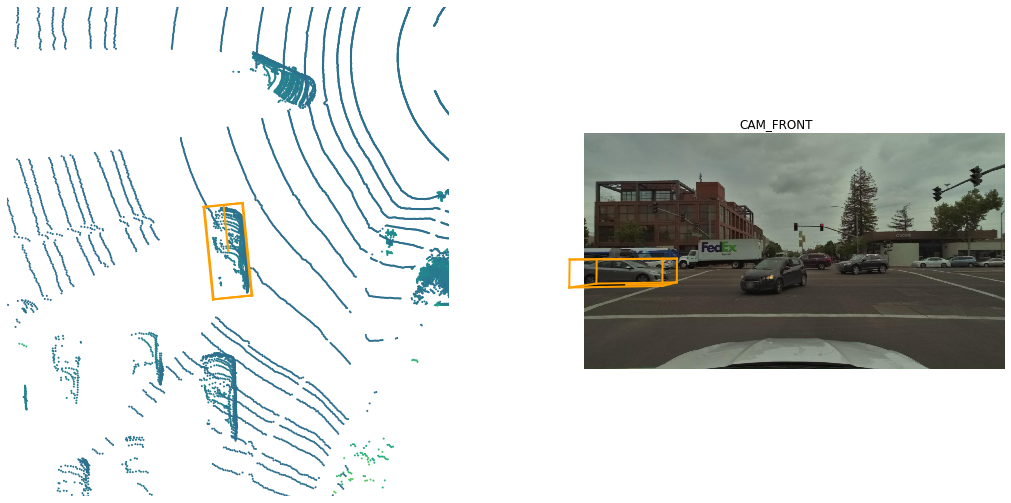

41: 401e8a8898ae2a07181290b1ae873391d426c7863aac4b1bba53bbca9e733875


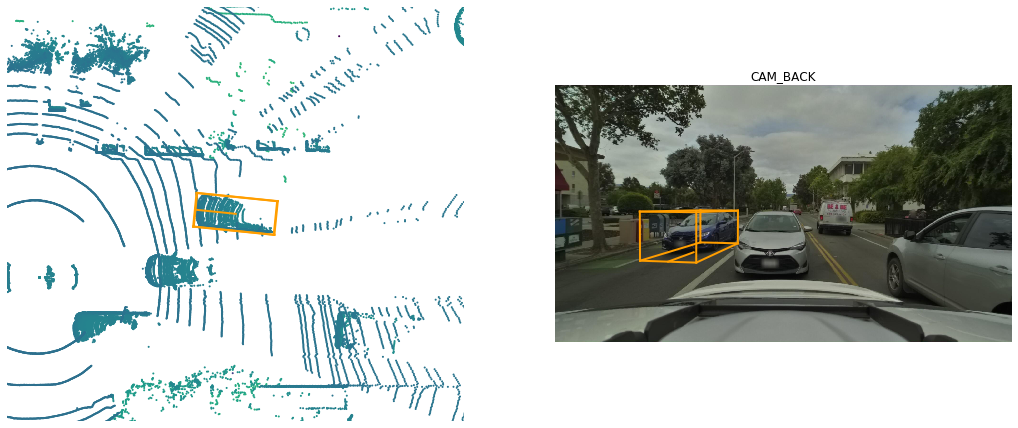

42: 76c6fff85161d291d26eee7d37e13b40b504257f40a3e03d40a4b876f40b354c


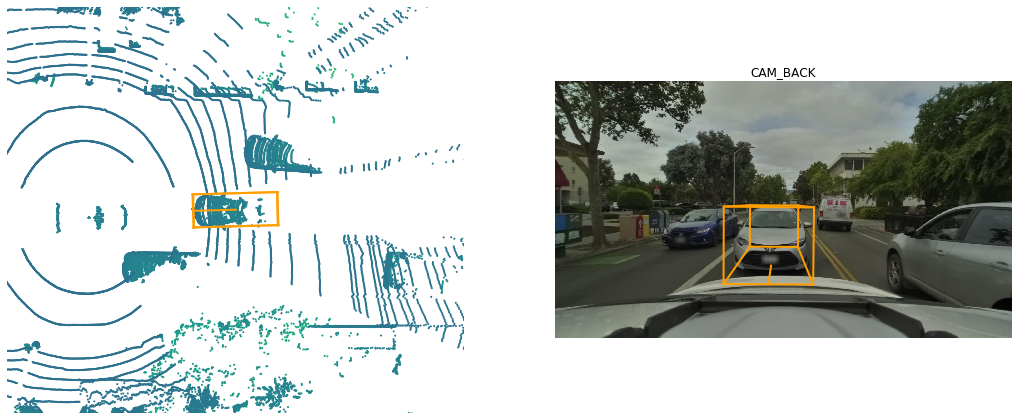

56: c1b8eaeefb86f38a8bca25896000719e517ef859985bb9d0cbf1955d4b26ffb1


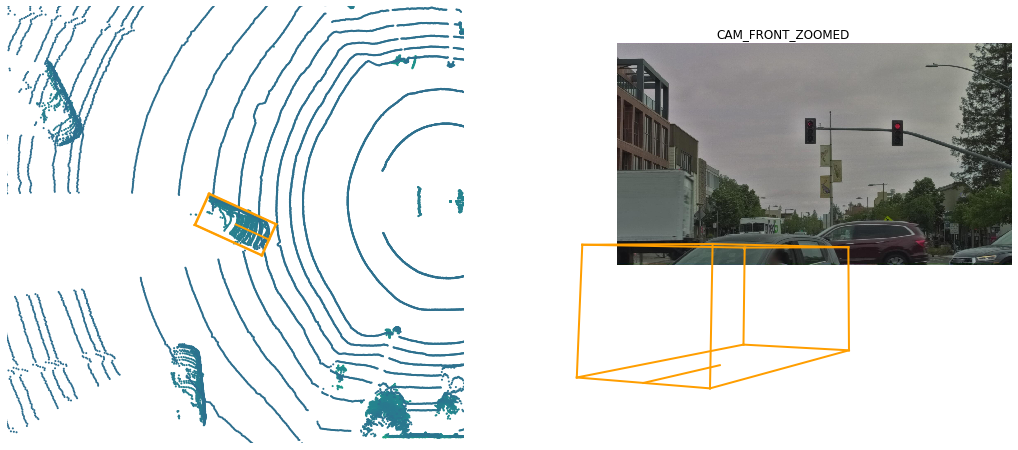

In [25]:
anns_inds_to_show = [13, 27, 41, 42, 56] # i select several cars near lyft's pod
ann_tokens = []
for ind in anns_inds_to_show:
    my_annotation_token = my_sample['anns'][ind]
    print(f'{ind}: {my_annotation_token}')
    ann_tokens.append(my_annotation_token)
    level5data.render_annotation(my_annotation_token)
    plt.show()

In [26]:
my_sample['data'].keys() # available sensors for sampling

dict_keys(['CAM_BACK', 'CAM_FRONT_ZOOMED', 'LIDAR_FRONT_RIGHT', 'CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK_LEFT', 'LIDAR_TOP', 'LIDAR_FRONT_LEFT'])

In [27]:
# here we get all objects (bboxes) for selected sensor and filter by selected cars (above)
ret_sampled = level5data.get_sample_data(lidar_top_data_token, selected_anntokens=ann_tokens)[1]
# we can not pass selected_anntokens and get full info of the bboxes around 
# car - literally a complete set of data for training a neural network

In [28]:
def get_data_from_sample(chanel_to_get):
    return level5data.get('sample_data', my_sample['data'][chanel_to_get])

In [29]:
def show_img_from_data(data):
    plt.imshow(
        cv2.cvtColor(
            cv2.imread(data['filename']),
            cv2.COLOR_BGR2RGB
        )
    );

In [30]:
lidar_channel = 'LIDAR_TOP'
camera1_chanel = 'CAM_BACK'
camera2_chanel = 'CAM_BACK_LEFT'
camera3_chanel = 'CAM_FRONT'
lidar_data = get_data_from_sample(lidar_channel)
camera1_data = get_data_from_sample(camera1_chanel)
camera2_data = get_data_from_sample(camera2_chanel)
camera3_data = get_data_from_sample(camera3_chanel)

# Let's take a look at the cars around us

In [31]:
# car 1 on back side
show_img_from_data(camera1_data);

error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# car 2 on back side
show_img_from_data(camera2_data);

In [ ]:
# car 3 on front side
show_img_from_data(camera3_data);

In [ ]:
pc = LidarPointCloud.from_file(Path(lidar_data['filename']))

In [ ]:
plot_offset = 15
plt.xlim(-plot_offset, plot_offset)
plt.ylim(-plot_offset, plot_offset)

# plot PointCloud
plt.scatter(pc.points[0, :], pc.points[1, :], c=pc.points[2, :], s=0.1);
# plot center of cars / bboxes
for cur_point_idx in range(len(ret_sampled)):
    crds = ret_sampled[cur_point_idx].center
    plt.scatter(crds[0], crds[1], c='red');

Here we see car silhouette.

Dive into data.
Points have x, y and z coords and intensity - always 100.

In [ ]:
pc.points[:, 0]

In [ ]:
(pc.points[3, :]==100).all()

Here we get ego centered coordinates of bbox, rotation and etc:

In [ ]:
sample_to_explore = ret_sampled[4]

In [ ]:
sample_to_explore

In [32]:
# rotation in radians of bbox: x, y and z. For degrees see example above (next MPL Figure)
sample_to_explore.orientation.yaw_pitch_roll

NameError: name 'sample_to_explore' is not defined

In [33]:
# Width, leght and height of bbox: x, y and z
sample_to_explore.wlh

NameError: name 'sample_to_explore' is not defined

In [34]:
# and of course coords of bbox 
sample_to_explore.center

NameError: name 'sample_to_explore' is not defined

In [35]:
# class of object
sample_to_explore.name

NameError: name 'sample_to_explore' is not defined

Now we have all ingridients!

NameError: name 'pc' is not defined

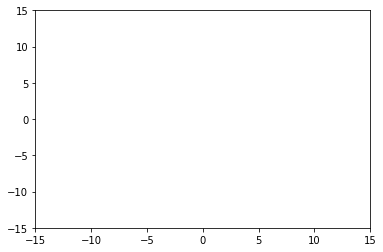

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)

plot_offset = 15
plt.xlim(-plot_offset, plot_offset)
plt.ylim(-plot_offset, plot_offset)

# plot PointCloud
ax.scatter(pc.points[0, :], pc.points[1, :], c=pc.points[2, :], s=0.1);

# plot center of cars / bboxes
crds = sample_to_explore.center
ax.scatter(crds[0], crds[1], c='red');

w, l, h  = sample_to_explore.wlh
angles_to_rotate = sample_to_explore.orientation.yaw_pitch_roll

rect_angle = math.degrees(angles_to_rotate[0]) # radians to degrees
mpl_rotate = (
    mpl
    .transforms
    .Affine2D()
    .rotate_deg_around(crds[0], crds[1], rect_angle)
    + ax.transData
)

rect = patches.Rectangle(
    (crds[0] - l / 2, crds[1] - w / 2), l, w, fill=False,
)

rect.set_transform(mpl_rotate)

ax.add_patch(rect);

Later we create pytorch dataloader, which provide all data for NN!